In [55]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from general.pulses import blackman_pulse, square_pulse
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += colors

from general.plot_settings import paper_settings
plt.rcParams.update(paper_settings)

The area of the square pulse is 0.9984
The area of the Blackman pulse is 0.4195800001922482
The area ratio is 0.42025240403871017
The area of the square pulse squared is 0.9984
The area of the Blackman pulse squared is 0.30429539999999966
The squared area ratio is 0.30478305288461505


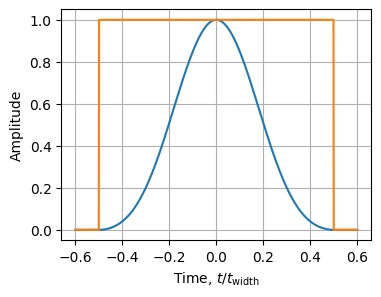

In [2]:
t_min, t_max = (-6, 6)
num = 1000
t = np.linspace(t_min, t_max, num)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(t/t_width, blackman_pulse(t+t_width/2, t_width))
ax.plot(t/t_width, square_pulse(t+t_width/2, t_width))
ax.grid(True)
ax.set(xlabel=r"Time, $t/t_\mathrm{width}$", ylabel="Amplitude")

dt = (t_max - t_min)/num/t_width
A_blackman = np.trapezoid(blackman_pulse(t+t_width/2, t_width), dx=dt)
A_square = np.trapezoid(square_pulse(t+t_width/2, t_width), dx=dt)
A2_blackman = np.trapezoid(blackman_pulse(t+t_width/2, t_width)**2, dx=dt)
A2_square = np.trapezoid(square_pulse(t+t_width/2, t_width)**2, dx=dt)

print(f"The area of the square pulse is {A_square}")
print(f"The area of the Blackman pulse is {A_blackman}")
print(f"The area ratio is {A_blackman/A_square}")

print(f"The area of the square pulse squared is {A2_square}")
print(f"The area of the Blackman pulse squared is {A2_blackman}")
print(f"The squared area ratio is {A2_blackman/A2_square}")

plt.show()

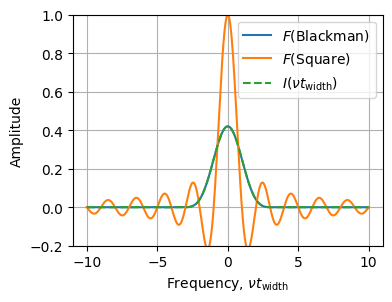

In [3]:
from general.pulses import blackman_fourier, blackman_instrument

nu = np.linspace(-1, 1, 1000)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu * t_width, blackman_fourier(nu, t_width)/t_width, label=r'$F$(Blackman)')
ax.plot(nu * t_width, t_width*np.sinc(t_width*nu)/t_width, label=r'$F$(Square)')
ax.plot(nu * t_width, blackman_instrument(nu, t_width)/t_width, '--', label=r'$I(\nu t_\mathrm{width})$')
ax.grid(True)
ax.set(xlabel=r"Frequency, $\nu t_\mathrm{width}$", ylabel="Amplitude", ylim=[-0.2, 1])
ax.legend(loc="upper right")

plt.show()

In [4]:
0.42


0.42

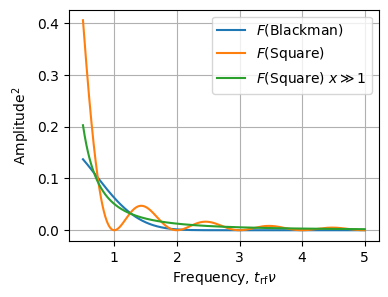

In [5]:
from general.pulses import blackman_fourier

nu = np.linspace(0.05, 0.5, 1000)

def large_x_sinc(x):
    return 1/np.sqrt(2)* np.piecewise(x, [x==0, x!=0], [1, lambda x: 1/(np.pi * x)])

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu * t_width, (blackman_fourier(nu, t_width)/t_width)**2, label=r'$F$(Blackman)')
ax.plot(nu * t_width, np.sinc(t_width*nu)**2, label=r'$F$(Square)')
ax.plot(nu * t_width, large_x_sinc(t_width*nu)**2, label=r'$F$(Square) $x\gg1$') 
ax.grid(True)
ax.set(xlabel=r"Frequency, $t_\mathrm{rf} \nu$", ylabel=r"Amplitude$^2$")
ax.legend(loc="upper right")

# ratio = (blackman_fourier(nu_test, t_width)/t_width)**2/large_x_sinc(t_width*nu_test)**2

# print(f"Average SquareFourier^2 at large x compared to BlackmanFourier^2 is {ratio}")

plt.show()

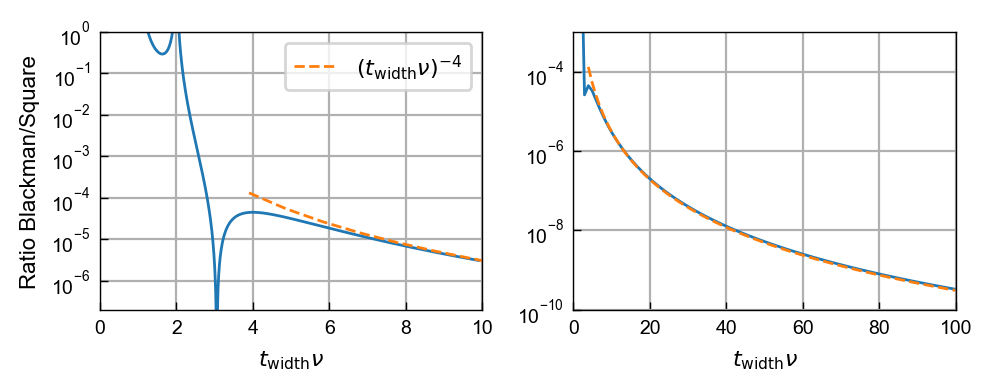

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))

def ratio_func(det):
    return (blackman_fourier(det, 1))**2/np.sinc(det)**2

ax = axs[0]
detuning = np.linspace(0.9, 9.9, 1000)
ax.plot(detuning, ratio_func(detuning))
detuning = np.linspace(3.9, 99.9, 100)
ax.plot(detuning, detuning**(-4)/33, '--', label=r'$(t_\mathrm{width} \nu)^{-4}$')
ax.grid(True)
ax.set(xlabel=r"$t_\mathrm{width} \nu$", ylabel=r"Ratio Blackman/Square",
       yscale='log', ylim=(2e-7, 1), xlim=(0, 10))
ax.minorticks_off()
ax.legend()

ax = axs[1]
detuning = np.linspace(0.9, 99.9, 100)
ax.plot(detuning, ratio_func(detuning))
detuning = np.linspace(3.9, 99.9, 100)
ax.plot(detuning, detuning**(-4)/33, '--')
ax.grid(True)
ax.set(xlabel=r"$t_\mathrm{width} \nu$", yscale='log', ylim=(1e-10, 1e-3), xlim=(0, 100))

fig.tight_layout()
fig.savefig("blackman_vs_square_pulse_detuning.pdf")

plt.show()

## Convolution of Blackman on -3/2s tail

For 10us pulse, norm is 0.029.
2.004943428648677
For 12us pulse, norm is 0.025.
1.6663538464045702
For 15us pulse, norm is 0.020.
1.3583956770462429
For 17us pulse, norm is 0.018.
1.2573600623886114
For 20us pulse, norm is 0.015.
1.1827891066214686
For 30us pulse, norm is 0.010.
1.105364613943884
For 40us pulse, norm is 0.008.
1.0830775615388446
For 60us pulse, norm is 0.005.
1.0682345364342385
For 120us pulse, norm is 0.003.
1.0597114486360382
For 200us pulse, norm is 0.002.
1.0579279316816517


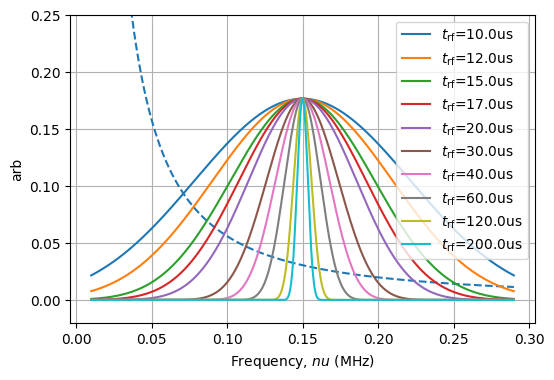

In [14]:
# --- Parameters ---
nu_s = 0.150            # Frequency shift of Blackman window.
gamma = 0.005            # Lorentzian HWHM (broad).
nu0 = 0.0              # Lorentzian center frequency.
x_i = gamma             # Lorentzian to -3/2s tail roll-over.
U_trap = 0.2            # Trap depth


def lorentzian(nu):
    return 1 / (1 + ((nu - nu0) / gamma) ** 2)


def spectrum(nu, x_i):
    cond_list = [nu <= x_i, nu > 0]
    crossover_y = lorentzian(x_i) * x_i**(3/2)
    func_list = [lorentzian, lambda x: crossover_y*x**(-3/2)]
    return np.piecewise(nu, cond_list, func_list)


def blackman_ft(nu, t_width):
    return (blackman_fourier(nu, t_width)/t_width)**2


samples = 1e5
nu_min = 0.01
nu_max = 2*nu_s - nu_min
nu = np.linspace(nu_min, nu_max, int(samples))

t_widths = np.array([10., 12., 15., 17., 20., 30., 40., 60., 120., 200., 
                     #2000., 20000.
                     ])  # us
M = np.zeros_like(t_widths)

fig, ax = plt.subplots(figsize=(6,4))
ax.set(xlabel=r"Frequency, $nu$ (MHz)", ylabel="arb", ylim=(-0.02, 0.25))

S = spectrum(nu, x_i=x_i)
S_norm = np.trapezoid(S, nu)
ax.plot(nu, S*10, '--', color=colors[len(t_widths)])
S /= S_norm

for i, t_width in enumerate(t_widths):
    color=colors[i]

    B_pulse = blackman_ft(nu - nu_s, t_width)
    ax.plot(nu, B_pulse, '-', color=color, label=r'$t_\mathrm{rf}$='+f'{t_width}us')

    B_norm = np.trapezoid(B_pulse, nu)
    B_pulse /= B_norm
    print(f"For {t_width:.0f}us pulse, norm is {B_norm:.3f}.")

    B = blackman_ft(nu_s - nu, t_width)/B_norm
    M[i] = np.trapezoid(S * B, nu)

    print(np.sum(S*B*(nu[1]-nu[0])))


ax.legend()
ax.grid(True)
plt.show()

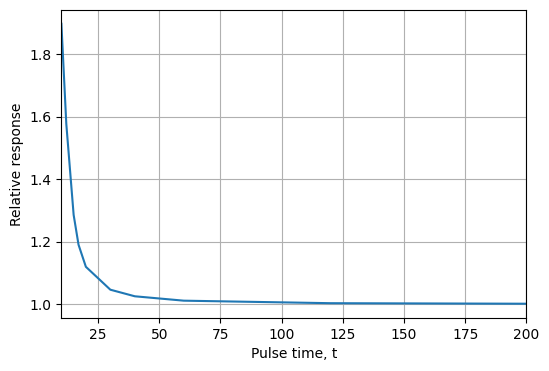

In [15]:
M_true = 1.05693002 # Taken from 20e3 us pulse

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t_widths, M/M_true)
ax.set(xlabel="Pulse time, t", ylabel="Relative response")
ax.set(xlim=(10, 200))
ax.grid(True)

plt.show()

In [ ]:
15/8 * (50/150)**2
max(B*B_norm)
0.17626117641547914/np.e

0.06484286307994748

## Single-particle residue contamination

### Fermi time or 11us pulse

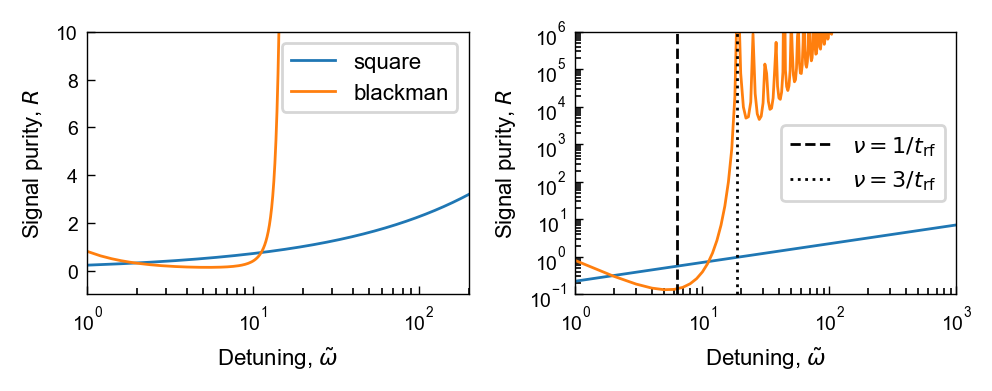

In [180]:
tau_F = 11e-6
trf = 11e-6

omega_trf = 2*np.pi/trf * tau_F

OmegaR = 2 / trf
C = 1

def alpha_HFT(omega):
    return 2**(-3/2)/np.pi * tau_F * trf * C * omega**(-3/2) * OmegaR**2

def alpha_res(omega):
    nu = omega/tau_F/2/np.pi
    return np.sinc(trf * nu)**2 * OmegaR**2 / 4 * trf**2

def alpha_res_lim(omega):
    return  OmegaR**2/(omega/tau_F)**2/2

def alpha_HFT_blackman(omega):
    return alpha_HFT(omega) * 0.305

def alpha_res_blackman(omega):
    nu = omega/tau_F/2/np.pi
    return (blackman_instrument(nu, trf)/trf)**2 * OmegaR**2 / 4 * trf**2

fig, axs = plt.subplots(1, 2, figsize=(5, 2))


ax = axs[0]
ylims = (-1, 10)
xlims = (1, 200)
detuning = np.linspace(*xlims, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$', 
       xscale='log', ylim=ylims, xlim=xlims)
ax.plot(detuning, alpha_HFT(detuning)/alpha_res_lim(detuning), label='square')
ax.plot(detuning, alpha_HFT_blackman(detuning)/alpha_res_blackman(detuning), label='blackman')

ax.legend()

ax = axs[1]
ylims = (0.1, 1e6)
xlims = (1, 1000)
detuning = np.linspace(*xlims, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$', 
       xscale='log', yscale='log', ylim=ylims, xlim=xlims)
ax.plot(detuning, alpha_HFT(detuning)/alpha_res_lim(detuning))
ax.plot(detuning, alpha_HFT_blackman(detuning)/alpha_res_blackman(detuning))
ax.vlines(omega_trf, *ylims, 'k', '--', label=r'$\nu = 1/t_\mathrm{rf}$')
ax.vlines(3*omega_trf, *ylims, 'k', ':', label=r'$\nu = 3/t_\mathrm{rf}$')
ax.legend()

fig.tight_layout()

fig.savefig("outputs/signal_purity.pdf")
plt.show()


In [190]:
nu = 14.5
alpha_HFT_blackman(nu)/alpha_res_blackman(nu)

np.float64(12.192158917960018)

In [194]:
1/(14.5*15e3/1e6)


4.597701149425287

### 200us pulse

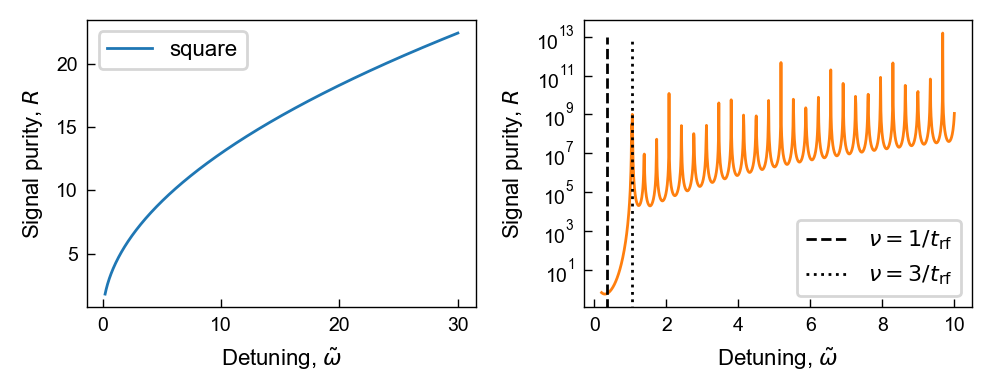

In [204]:
tau_F = 11e-6
trf = 200e-6

omega_trf = 2*np.pi/trf * tau_F

OmegaR = 2 / trf
C = 1

def alpha_HFT(omega):
    return 2**(-3/2)/np.pi * tau_F * trf * C * omega**(-3/2) * OmegaR**2

def alpha_res(omega):
    nu = omega/tau_F/2/np.pi
    return np.sinc(trf * nu)**2 * OmegaR**2 / 4 * trf**2

def alpha_res_lim(omega):
    return  OmegaR**2/(omega/tau_F)**2/2

def alpha_HFT_blackman(omega):
    return alpha_HFT(omega) * 0.305

def alpha_res_blackman(omega):
    nu = omega/tau_F/2/np.pi
    return (blackman_instrument(nu, trf)/trf)**2 * OmegaR**2 / 4 * trf**2

fig, axs = plt.subplots(1, 2, figsize=(5, 2))


ax = axs[0]
detuning = np.linspace(0.2, 30, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$')
ax.plot(detuning, alpha_HFT(detuning)/alpha_res_lim(detuning), label='square')

ax.legend()

ax = axs[1]
ylims = (0.1, 1e13)
xlims = (0.2, 10)
detuning = np.linspace(*xlims, 1000)
ax.set(xlabel=r"Detuning, $\tilde \omega$", ylabel=r'Signal purity, $R$', 
       yscale='log')
ax.plot(detuning, alpha_HFT_blackman(detuning)/alpha_res_blackman(detuning), color=colors[1])
ax.vlines(omega_trf, *ylims, 'k', '--', label=r'$\nu = 1/t_\mathrm{rf}$')
ax.vlines(3*omega_trf, *ylims, 'k', ':', label=r'$\nu = 3/t_\mathrm{rf}$')
ax.legend()

fig.tight_layout()

fig.savefig("outputs/signal_purity_200us.pdf")
plt.show()

In [80]:
0.42**2

0.17639999999999997

## Dimer signal contamination

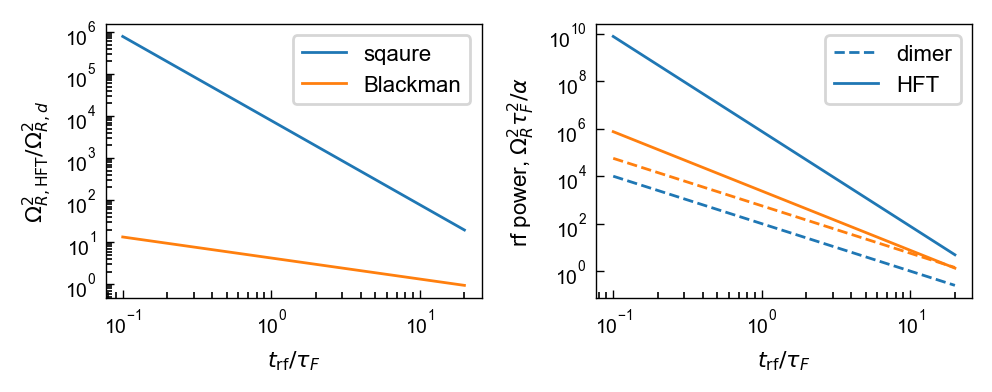

In [203]:
# import numpy as np
# R = 1
# omega_tilde_factors = (np.sqrt(2) * np.pi * 0.18**2 * (2*np.pi)**4/0.305)**(2/9)

# num_factors = omega_tilde_factors**6 * 2 /((2*np.pi)**4 * 0.18**2)

# print(num_factors/1e4)
# omega_d = 2*np.pi*4e6
# C = 1
# kF_ell_d = 4*np.pi/1e2
# R = 10
# factor = ((2*np.pi)**5*R/kF_ell_d/C * 0.18**2/0.42**2)**(1/6)
# trf = omega_d**(-1) * factor

# trf*1e6
# factor
# R = 10
# C = 1

# ratio = (0.026)*(0.42**2) * kF_ell_d/4/np.pi * R**(1/3) /C**(1/3)
# ratio
# (0.18**2 * (2*np.pi)**4 * np.sqrt(2)*np.pi / 0.305)**(2/9)
# 4.3*10**(2/9) * 15

tau_F = 11e-6
omega_d = 2*np.pi * 4e6
C = 1
kF_ell_d = 4*np.pi / 1e2
R = 10

def dimer_power(t):
    """Dimer power as \Omega_R^2\tau_F^2/\alpha_d as a function of
    time in Fermi time units."""
    return 4*np.pi/kF_ell_d/C *t**(-2)

def dimer_power_blackman(t):
    """Dimer power as \Omega_R^2\tau_F^2/\alpha_d as a function of
    time in Fermi time units, for a Blackman pulse."""
    return 4*np.pi/kF_ell_d/C *t**(-2) / 0.42**2

def hft_power(t):
    """HFT power as \Omega_R^2\tau_F^2/\alpha_HFT as a function of
    time in Fermi time units."""
    return 8*np.pi**4 * R**3/C**4 *t**(-4)

def hft_power_blackman(t):
    prefactor = 2*np.sqrt(2)*np.pi*(6*np.pi)**(3/2)/0.305
    return prefactor / C * t**(-5/2)

fig, axs = plt.subplots(1, 2, figsize=(5,2))

ax = axs[1]
ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'rf power, $\Omega_R^2\tau_F^2/\alpha$',
       yscale='log', xscale='log')

t = np.linspace(0.1, 20, 100)
ax.plot(t, dimer_power(t), '--', label='dimer', color=colors[0])
ax.plot(t, hft_power(t), label='HFT', color=colors[0])

ax.plot(t, dimer_power_blackman(t), '--', color=colors[1])
ax.plot(t, hft_power_blackman(t),  color=colors[1])
ax.legend()


ax = axs[0]
ax.set(xlabel=r"$t_\mathrm{rf}/\tau_F$", 
       ylabel=r'$\Omega_{R,\mathrm{HFT}}^2/\Omega_{R,d}^2$',
       yscale='log', xscale='log')

ax.plot(t, hft_power(t)/dimer_power(t), label='sqaure')
ax.plot(t, hft_power_blackman(t)/dimer_power_blackman(t), label='Blackman')
ax.legend()

fig.tight_layout()
fig.savefig("outputs/dimer_vs_HFT_power.pdf")

plt.show()




In [175]:
2*np.sqrt(2)*np.pi*(6*np.pi)**(3/2)/0.305

np.float64(2384.222112118256)

In [178]:
3/4

0.75

## Plot for figures

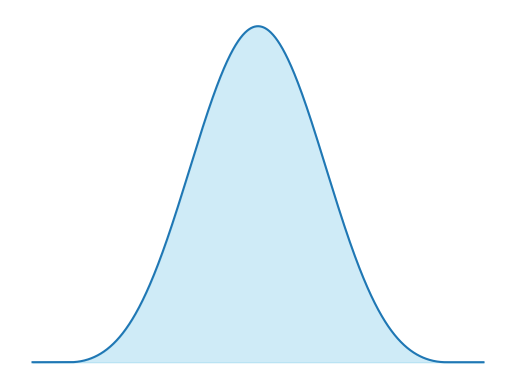

In [ ]:
t = np.linspace(-0.1, 1.1, 1000)
t_width = 1

y = blackman_pulse(t, t_width)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.fill_between(t, y, color='skyblue', alpha=0.4) 
# plt.plot(t, square_pulse(t, t_width))
ax.set(xlabel="Time, t", ylabel="Amplitude")

ax.axis('off')

plt.show()

# fig.savefig("outputs/blackman_envelope_with_fill.pdf")

## Understanding a_1 coefficient sign

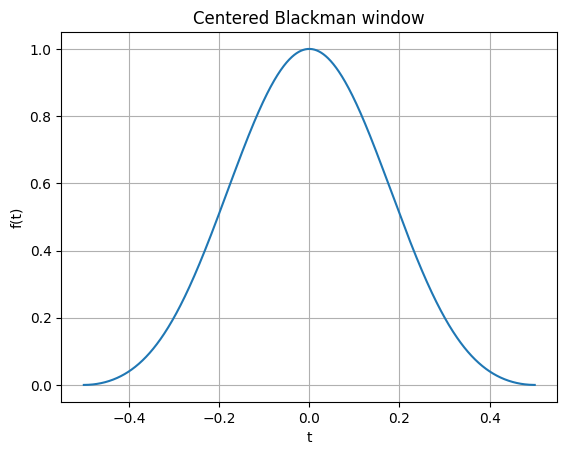

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.16
a0 = (1 - alpha)/2
a1 = 0.5
a2 = alpha/2

t_w = 1.0
t = np.linspace(-t_w/2, t_w/2, 1000)
f = a0 + a1*np.cos(2*np.pi*t/t_w) + a2*np.cos(4*np.pi*t/t_w)

plt.plot(t, f)
plt.title("Centered Blackman window")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.show()
